# Model Analysis
This notebook trains a machine learning model to predict LaLiga match outcomes. The model classifies each match as:
- **1**: Home team wins
- **3**: Away team wins
- **2**: Draw

## Step 1: Data Preprocessing

In [1]:
# import libraries ncessary for preprocessing
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import train_test_split

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the matches table from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)

# close the connection of the database
con.close()

In [6]:
def count_points(last_5):
    if last_5 == 0:
        return 0
        
    count = 0
    for i in last_5:
        if i == 'W':
            count += 3
        elif i == 'T':
            count += 1
    return count

def extend_data(input_data):
    # clean the inputted dataframe
    # make a copy of the data so the original dataframe does not change
    data = input_data.copy()
    
    # drop the "time" column because it contains to many "None" values, and the "date" column because it is not used
    data.drop(columns = ['time', 'date'], inplace = True)
    
    # drop NaN values (there are only NaN values left in the "score" column)
    data.dropna(inplace = True)
    
    # create two new columns, one for the score of the home team, and one for the score of the away team, drop the score column
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data.drop(columns=['score'], inplace = True)
    
    # create a new column to show which team won (1 for home team, 2 for away team and 'X' for a draw)
    data['winner'] = data.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 2 if row['home_score'] < row['away_score'] else 'X', axis=1)


    # use the code from exercise 10 to gather more data for the matches
    # make a copy of the data dataframe so the original dataframe does not change
    data_copy = data

    # calculate, for every unique group of season, division, matchday and home_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    home_stats = data_copy.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF=('home_score', 'sum'), GA=('away_score', 'sum'),
        W=('winner', lambda x: (x == 1).sum()),
        L=('winner', lambda x: (x == 2).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'home_team': 'team', 'result': 'home_result'})

    # calculate, for every unique group of season, division, matchday and away_team, how many goals the team made (GF) and got against (GA)
    # and if the team won (W=1), lost (L=1) or tied (T=1)
    away_stats = data_copy.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF=('away_score', 'sum'), GA=('home_score', 'sum'),
        W=('winner', lambda x: (x == 2).sum()),
        L=('winner', lambda x: (x == 1).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'away_team': 'team', 'result': 'away_result'})

    # add the statestics for the home teams and the away teams together
    combined_stats = pd.concat([home_stats, away_stats]).fillna(0)
    # calculate the goal difference for each row, a negative goal difference means the team got more goals against then that it made
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    # calculate the amount of points for each row, a win is worth 3 points, and a tie 1
    combined_stats['Pts'] = combined_stats['W'] * 3 + combined_stats['T']
    # create a result column that contains "W" if the team one the match, 'L' if the team lost the match and "T" if the team tied the match
    combined_stats['result'] = combined_stats.apply(lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1)

    # sort the combined statistics so they are in the right order
    results = combined_stats.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'])
    # cumulative sum 'GF', 'GA', 'GD', 'W', 'L', 'T' and 'Pts', so that it is updated for every matchday
    results[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = results.groupby(['season', 'division', 'team'])[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']].cumsum()

    # sort the dataframe again so that the rank can be calculated
    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])    
    # calculate the rank
    results['rank'] = results.groupby(['season', 'division', 'matchday']).cumcount() + 1
    # sort the dataframe so everything is in the right order
    results = results.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)

    # create a column with the last 5 results of the team in the same season and division
    results['last_5'] = results.apply(lambda row: results[
        (results['season'] == row['season']) &
        (results['division'] == row['division']) &
        (results['matchday'] <= row['matchday']) &
        (results['matchday'] >= max(1, row['matchday'] - 4)) &
        (results['team'] == row['team'])
    ]['result'].tolist()[-5:], axis=1)

    # count the amount of points the last 5 results would total to
    results['last_5'] = results['last_5'].apply(lambda x: count_points(x))  
    
    # the final result dataframe
    results = results[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result', 'last_5']]

    
    # shift the results dataframe so that it can be combined with the data dataframe later
    # make a copy of the results dataframe so the original dataframe does not change
    results_shifted = results.copy()
    # shift the matchday up by 1 so that the results dataframe will merge good with the data dataframe
    results_shifted['matchday'] += 1
    
    # rename the columns so that that values are clear, the values are from just before the matchday where they are shown started
    results_shifted = results_shifted.rename(columns={
        'rank': 'prev_rank',
        'GF': 'prev_GF', 'GA': 'prev_GA', 'GD': 'prev_GD',
        'W': 'prev_W', 'L': 'prev_L', 'T': 'prev_T', 'Pts': 'prev_Pts',
        'result': 'prev_result', 'last_5': 'prev_last_5'
    })
    
    # merge the data dataframe with the shifted results dataframe, first only for the home teams
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'home_team'], 
                      right_on=['season', 'division', 'matchday', 'team']).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)
    
    # merge the data dataframe again with the shifted results dataframe, now for the away teams, and ensure the prefixes are correct
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'away_team'], 
                      right_on=['season', 'division', 'matchday', 'team'], 
                      suffixes=('_home', '_away')).fillna(0)
    
    # drop the team column that was created
    data.drop(columns=['team'], inplace=True)

    # space to add extra data to the data dataframe or change existing data
    data['winner'] = data.apply(lambda row: 1 if row['winner'] == 1 else 2 if row['winner'] == 2 else 0, axis=1)

    data['GDD'] = (data['prev_GD_home'] - data['prev_GD_away']) / data['matchday']






    # Create a helper column to represent team pairs in an unordered manner
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)
    
    # Group by 'team_pair' instead of separate home and away teams to include all matches between the two teams
    data['head_to_head_last_5'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 1) / 5, raw=True)
    )











    

    # 1. Head-to-Head Draw Ratio in the last 5 matches
    data['head_to_head_draw_ratio'] = data.groupby('team_pair')['winner'].transform(
        lambda x: x.shift(1).rolling(5, 1).apply(lambda y: sum(y == 'X') / 5, raw=True)
    )
    
    # 2. Head-to-Head Average Goals Scored by Home Team in the last 5 matches
    data['head_to_head_avg_goals_home'] = data.groupby('team_pair')['home_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean()
    )
    
    # 3. Head-to-Head Average Goals Scored by Away Team in the last 5 matches
    data['head_to_head_avg_goals_away'] = data.groupby('team_pair')['away_score'].transform(
        lambda x: x.shift(1).rolling(5, 1).mean()
    )














    # 4. Head-to-Head Goal Difference (Home Goals - Away Goals) in the last 5 matches
    data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
        lambda x: (x['home_score'] - x['away_score']).shift(1).rolling(5, 1).mean()
    ).reset_index(level=0, drop=True)





















    
    
    # Drop the helper column to clean up the dataframe
    data.drop(columns=['team_pair'], inplace=True)






    return data

# Additional imports if necessary
from collections import Counter

def extend_data_with_h2h(input_data):
    # Call the original function to get the extended data first
    data = extend_data(input_data)

    # Step 1: Add Head-to-Head Statistics
    data['team_pair'] = data.apply(lambda row: frozenset([row['home_team'], row['away_team']]), axis=1)

    # Filter relevant columns for head-to-head calculations
    h2h_data = data[['season', 'division', 'matchday', 'home_team', 'away_team', 'home_score', 'away_score', 'winner', 'team_pair']]

    # Step 2: Initialize new columns for H2H statistics
    data['h2h_last_5_wins_home'] = 0
    data['h2h_last_5_wins_away'] = 0
    data['h2h_last_5_draws'] = 0
    data['h2h_last_5_goals_home'] = 0
    data['h2h_last_5_goals_away'] = 0

    # Define a function to retrieve the last 5 head-to-head games (excluding the current match)
    def get_h2h_stats(row, h2h_data):
        team_pair = row['team_pair']
        matchday = row['matchday']
        season = row['season']

        # Get the last 5 matches between the two teams *before* the current match
        h2h_matches = h2h_data[
            (h2h_data['team_pair'] == team_pair) &
            ((h2h_data['season'] < season) | 
             ((h2h_data['season'] == season) & (h2h_data['matchday'] < matchday)))
        ].sort_values(by=['season', 'matchday'], ascending=[False, False]).head(5)

        # Count the results of these last 5 matches
        home_wins = sum(h2h_matches['winner'] == 1)
        away_wins = sum(h2h_matches['winner'] == 2)
        draws = sum(h2h_matches['winner'] == 'X')
        
        # Calculate the goals scored in these head-to-head matches
        goals_home = h2h_matches['home_score'].sum()
        goals_away = h2h_matches['away_score'].sum()

        return home_wins, away_wins, draws, goals_home, goals_away

    # Apply the function to each row to populate new columns
    h2h_stats = data.apply(lambda row: get_h2h_stats(row, h2h_data), axis=1)
    data[['h2h_last_5_wins_home', 'h2h_last_5_wins_away', 'h2h_last_5_draws', 'h2h_last_5_goals_home', 'h2h_last_5_goals_away']] = pd.DataFrame(h2h_stats.tolist(), index=data.index)

    # Drop the helper column used for unique team pairs
    data.drop(columns=['team_pair'], inplace=True)

    # Return the final extended dataframe with additional H2H statistics
    return data

In [7]:
# select the right seasons for the training and testing data
training_data = df_matches[df_matches['season'].isin(['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]
testing_data_1 = df_matches[df_matches['season'].isin(['2017-2018', '2018-2019', '2019-2020','2020-2021'])]
testing_data_2 = df_matches[df_matches['season'].isin(['1928-1929', '1929-1930', '1930-1931','1931-1932'])]
testing_data_3 = df_matches[df_matches['season'].isin(['1954-1955', '1955-1956', '1956-1957','1957-1958'])]

In [8]:
# extend the training data
training_data = extend_data_with_h2h(training_data)
training_data

/tmp/ipykernel_29892/4168147013.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(


,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,2007-2008,1,1,Real Madrid,Atlético Madrid,2,1,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2007-2008,1,1,Sevilla FC,Getafe,4,1,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,2007-2008,1,1,Athletic,CA Osasuna,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2007-2008,1,1,Dep. La Coruña,UD Almería,0,3,2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2007-2008,1,1,RCD Mallorca,Levante,3,0,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10941,2019-2020,2,42,CD Numancia,CD Tenerife,2,1,1,20.0,43.0,...,0.6,0.0,1.800000,0.8,1.000000,3,0,0,9,4
10942,2019-2020,2,42,Racing,Rayo Vallecano,1,2,2,22.0,38.0,...,0.4,0.0,2.333333,1.0,1.333333,2,0,0,7,3
10943,2019-2020,2,42,Sporting Gijón,SD Huesca,0,1,2,11.0,40.0,...,0.6,0.0,1.000000,0.8,0.200000,3,1,0,5,4
10944,2019-2020,2,42,Real Zaragoza,Ponferradina,2,1,1,5.0,57.0,...,0.4,0.0,1.800000,0.8,1.000000,2,0,0,9,4


In [9]:
training_data[((training_data['home_team'] == 'Dep. La Coruña') & (training_data['away_team'] == 'CF Fuenlabrada')) | ((training_data['home_team'] == 'CF Fuenlabrada') & (training_data['away_team'] == 'Dep. La Coruña'))]

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
10631,2019-2020,2,14,CF Fuenlabrada,Dep. La Coruña,1,1,0,3.0,18.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
10945,2019-2020,2,42,Dep. La Coruña,CF Fuenlabrada,2,1,1,19.0,41.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,1,1


In [10]:
training_data[((training_data['home_team'] == 'Barcelona') & (training_data['away_team'] == 'Real Madrid')) | ((training_data['home_team'] == 'Real Madrid') & (training_data['away_team'] == 'Barcelona'))]

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
168,2007-2008,1,17,Barcelona,Real Madrid,0,1,2,2.0,32.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
358,2007-2008,1,36,Real Madrid,Barcelona,4,1,1,1.0,73.0,...,0.0,0.0,0.0,1.000000,-1.000000,0,1,0,0,1
521,2008-2009,1,15,Barcelona,Real Madrid,2,0,1,1.0,44.0,...,0.2,0.0,2.0,1.000000,1.000000,1,1,0,4,2
710,2008-2009,1,34,Real Madrid,Barcelona,2,6,2,2.0,77.0,...,0.4,0.0,2.0,0.666667,1.333333,2,1,0,6,2
878,2009-2010,1,12,Barcelona,Real Madrid,1,0,1,2.0,29.0,...,0.4,0.0,2.0,2.000000,0.000000,2,2,0,8,8
1064,2009-2010,1,31,Real Madrid,Barcelona,0,2,2,1.0,83.0,...,0.6,0.0,1.8,1.600000,0.200000,3,2,0,9,8
1269,2010-2011,1,13,Barcelona,Real Madrid,5,0,1,2.0,33.0,...,0.6,0.0,1.8,1.800000,0.000000,3,2,0,9,9
1453,2010-2011,1,32,Real Madrid,Barcelona,1,1,0,2.0,72.0,...,0.6,0.0,2.0,1.600000,0.400000,3,2,0,10,8
1672,2011-2012,1,16,Real Madrid,Barcelona,1,3,2,1.0,53.0,...,0.4,0.0,1.8,1.800000,0.000000,2,2,0,9,9
1862,2011-2012,1,35,Barcelona,Real Madrid,1,2,2,2.0,100.0,...,0.4,0.0,1.6,1.200000,0.400000,2,2,0,8,6


In [11]:
training_data = training_data.fillna(0)

In [12]:
# extend the testing data
testing_data_1 = extend_data_with_h2h(testing_data_1)
testing_data_1
testing_data_2 = extend_data_with_h2h(testing_data_2)
testing_data_2
testing_data_3 = extend_data_with_h2h(testing_data_3)
testing_data_3

/tmp/ipykernel_29892/4168147013.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_29892/4168147013.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['head_to_head_goal_diff'] = data.groupby('team_pair').apply(
/tmp/ipykernel_29892/4168147013.py:182: DeprecationWarning: DataFrameGroupBy.apply operated on the groupin

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,1954-1955,1,1,Real Madrid,Valencia,1,2,2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,1954-1955,1,1,UD Las Palmas,Atlético Madrid,4,1,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,1954-1955,1,1,Barcelona,Sevilla FC,4,2,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
3,1954-1955,1,1,Real Valladolid,Real Sociedad,1,0,1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,1954-1955,1,1,CD Málaga,Celta de Vigo,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1957-1958,2,34,Girona,Racing,1,0,1,10.0,41.0,...,0.2,0.0,1.333333,1.000000,0.333333,1,1,0,4,3
1882,1957-1958,2,34,Indauchu,Tarrasa,3,1,1,4.0,61.0,...,0.6,0.0,3.000000,1.200000,1.800000,3,0,0,15,6
1883,1957-1958,2,34,Rayo Vallecano,Real Oviedo,0,2,2,7.0,44.0,...,0.6,0.0,3.000000,0.666667,2.333333,3,0,0,9,2
1884,1957-1958,2,34,CE Sabadell,CyD Leonesa,3,0,1,1.0,58.0,...,0.2,0.0,2.333333,1.666667,0.666667,1,2,0,7,5


In [13]:
testing_data_1 = testing_data_1.fillna(0)
testing_data_2 = testing_data_2.fillna(0)
testing_data_3 = testing_data_3.fillna(0)

In [14]:
def remove_first_three_seasons(data):
    # Identify the first three unique seasons in the dataset
    first_three_seasons = data['season'].sort_values().unique()[:3]
    
    # Filter out rows that belong to these first three seasons
    filtered_data = data[~data['season'].isin(first_three_seasons)]
    
    return filtered_data

# remove the first 3 years of both datasets
training_data = remove_first_three_seasons(training_data)
testing_data_1 = remove_first_three_seasons(testing_data_1)
testing_data_2 = remove_first_three_seasons(testing_data_2)
testing_data_3 = remove_first_three_seasons(testing_data_3)

In [15]:
training_data['winner'].value_counts()

winner
1    3927
0    2268
2    2225
Name: count, dtype: int64

In [16]:
from sklearn.utils import resample, under

# Separate each class into different DataFrames
class_1 = training_data[training_data['winner'] == 1]
class_0 = training_data[training_data['winner'] == 0]
class_2 = training_data[training_data['winner'] == 2]

# Find the size of the majority class
majority_size = class_1.shape[0]

# Oversample the minority classes to match the majority class size
class_0_oversampled = resample(class_0, replace=True, n_samples=majority_size, random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=majority_size, random_state=42)

# Concatenate the oversampled minority classes with the majority class
balanced_training_data = pd.concat([class_1, class_0_oversampled, class_2_oversampled])

# Shuffle the balanced data
balanced_training_data = balanced_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
balanced_training_data['winner'].value_counts()


ImportError: cannot import name 'under' from 'sklearn.utils' (/home/jonas/PycharmProjects/researchandinnovation/.venv/lib/python3.12/site-packages/sklearn/utils/__init__.py)

In [17]:
balanced_training_data = training_data.copy()
minority_cat = min(balanced_training_data['winner'].value_counts()) 

balanced_training_data = pd.concat([
    balanced_training_data[balanced_training_data['winner'] == 0].sample(minority_cat, random_state=42),
    balanced_training_data[balanced_training_data['winner'] == 1].sample(minority_cat, random_state=42),
    balanced_training_data[balanced_training_data['winner'] == 2].sample(minority_cat, random_state=42)
]).reset_index(drop=True)

balanced_training_data['winner'].value_counts()


winner
0    2225
1    2225
2    2225
Name: count, dtype: int64

In [18]:
balanced_training_data

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,head_to_head_last_5,head_to_head_draw_ratio,head_to_head_avg_goals_home,head_to_head_avg_goals_away,head_to_head_goal_diff,h2h_last_5_wins_home,h2h_last_5_wins_away,h2h_last_5_draws,h2h_last_5_goals_home,h2h_last_5_goals_away
0,2012-2013,1,9,Celta de Vigo,Dep. La Coruña,1,1,0,13.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0,4,4
1,2013-2014,2,16,Alavés,Ponferradina,2,2,0,19.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,2019-2020,2,28,Ponferradina,Extremadura,0,0,0,11.0,35.0,...,0.0,0.0,1.0,1.0,0.0,0,0,0,1,1
3,2011-2012,2,14,UD Las Palmas,Xerez CD,0,0,0,11.0,19.0,...,0.4,0.0,1.0,1.4,-0.4,2,2,0,5,7
4,2017-2018,1,26,Real Betis,Real Sociedad,0,0,0,7.0,43.0,...,0.6,0.0,2.0,1.6,0.4,3,1,0,10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,2014-2015,2,29,UD Las Palmas,Real Betis,0,3,2,1.0,46.0,...,0.4,0.0,1.6,0.8,0.8,2,0,0,8,4
6671,2010-2011,2,7,Xerez CD,SD Huesca,1,3,2,6.0,9.0,...,0.2,0.0,1.5,1.0,0.5,1,0,0,3,2
6672,2010-2011,2,23,Real Valladolid,Granada CF,2,3,2,15.0,28.0,...,0.4,0.0,1.4,0.8,0.6,0,1,0,0,1
6673,2011-2012,2,36,UD Las Palmas,SD Huesca,1,3,2,10.0,46.0,...,0.2,0.0,0.8,0.4,0.4,1,0,0,4,2


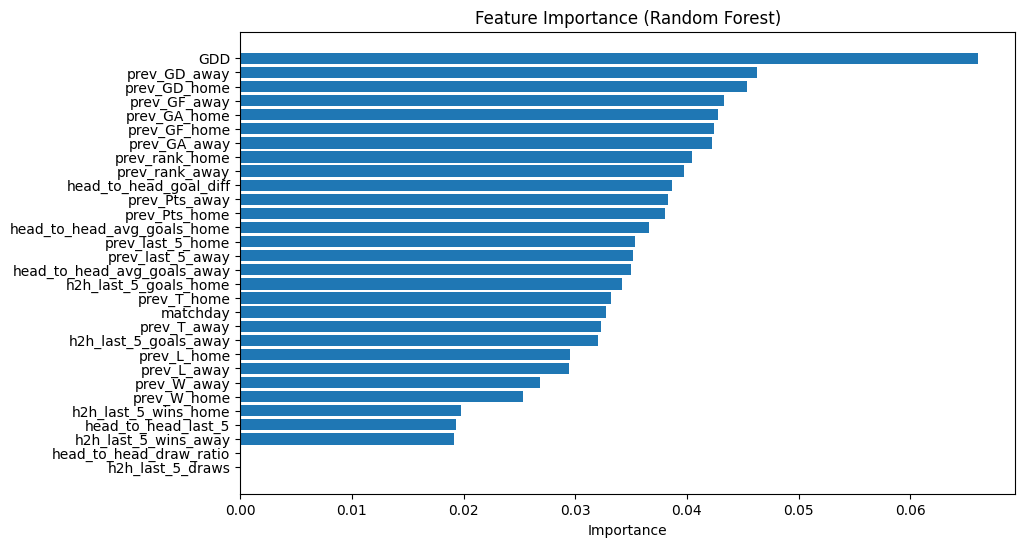

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
import matplotlib.pyplot as plt
import pandas as pd

# Assuming balanced_training_data is ready and 'winner' is the target
X = balanced_training_data.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season', 'home_score', 'away_score']).select_dtypes(include=[np.number])
y = balanced_training_data["winner"]

# Method 1: Feature Importance using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

# # Method 2: Recursive Feature Elimination (RFE)
# from sklearn.linear_model import LogisticRegression

# rfe_model = LogisticRegression(max_iter=1000, random_state=42)
# rfe = RFE(estimator=rfe_model, n_features_to_select=15)
# rfe.fit(X, y)

# # Get top features selected by RFE
# rfe_features = X.columns[rfe.support_]
# print("\nTop features selected by RFE:", rfe_features)

# # Method 3: SelectKBest with Chi-Square
# # SelectKBest works best with positive features, so ensure non-negative data
# X_non_negative = X.apply(lambda x: x + abs(x.min()) if x.min() < 0 else x)

# k_best = SelectKBest(score_func=chi2, k=15)
# k_best.fit(X_non_negative, y)

# # Get top features selected by SelectKBest
# k_best_features = X.columns[k_best.get_support()]
# print("\nTop features selected by SelectKBest:", k_best_features)


In [20]:
list(balanced_training_data.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season', 'home_score', 'away_score']).select_dtypes(include=[np.number]).columns)

['matchday',
 'prev_rank_home',
 'prev_GF_home',
 'prev_GA_home',
 'prev_GD_home',
 'prev_W_home',
 'prev_L_home',
 'prev_T_home',
 'prev_Pts_home',
 'prev_last_5_home',
 'prev_rank_away',
 'prev_GF_away',
 'prev_GA_away',
 'prev_GD_away',
 'prev_W_away',
 'prev_L_away',
 'prev_T_away',
 'prev_Pts_away',
 'prev_last_5_away',
 'GDD',
 'head_to_head_last_5',
 'head_to_head_draw_ratio',
 'head_to_head_avg_goals_home',
 'head_to_head_avg_goals_away',
 'head_to_head_goal_diff',
 'h2h_last_5_wins_home',
 'h2h_last_5_wins_away',
 'h2h_last_5_draws',
 'h2h_last_5_goals_home',
 'h2h_last_5_goals_away']

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# standard features
# features = ['prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away', 'GDD', 'prev_T_home', 'prev_T_away'] 
# features = ['GDD', 'prev_GD_home', 'prev_GD_away', 'prev_GF_home', 'prev_GF_away', 'prev_GA_home', 
#             'prev_GA_away', 'prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away',
#             'prev_T_home', 'prev_T_away']
features = ['GDD', 'prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away', 
            'prev_L_home', 'prev_L_away', ]\
# features = ['head_to_head_goal_diff', 'head_to_head_last_5']

y_train = y
y_test = testing_data_1["winner"]
accuracy_total_list = []

feature_list = feature_importance_df["Feature"].to_list()
for i in range(1, 15):#len(feature_list)):
    print(i)
    features = feature_list[0:i]

    X_train = X[features]
    X_test = testing_data_1[features]
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Support Vector Machine": SVC(kernel="linear"),
        "Naive Bayes Gaussian": GaussianNB()
    }

    accuracy_list = []
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Classification report
        report = classification_report(y_test, y_pred, target_names=["Tie (0)", "Home Win (1)", "Away Win (2)"], output_dict=True)
        accuracy_list.append(report['accuracy'])

    accuracy_total_list.append(accuracy_list)

print(accuracy_total_list)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
[[0.4323040380047506, 0.3669833729216152, 0.4346793349168646, 0.42992874109263657], [0.43824228028503565, 0.33729216152019004, 0.4311163895486936, 0.42992874109263657], [0.4346793349168646, 0.3669833729216152, 0.42755344418052255, 0.4180522565320665], [0.42992874109263657, 0.3836104513064133, 0.4144893111638955, 0.41330166270783847], [0.4334916864608076, 0.39311163895486934, 0.41092636579572445, 0.40973871733966744], [0.4334916864608076, 0.3978622327790974, 0.40973871733966744, 0.4026128266033254], [0.4334916864608076, 0.39311163895486934, 0.41211401425178146, 0.40617577197149646], [0.42161520190023755, 0.38954869358669836, 0.4251781472684085, 0.40973871733966744], [0.41211401425178146, 0.3978622327790974, 0.4144893111638955, 0.42755344418052255], [0.4144893111638955, 0.40380047505938244, 0.41211401425178146, 0.4251781472684085], [0.40973871733966744, 0.37885985748218526, 0.41092636579572445, 0.42280285035629456], [0.4002375296912114, 0.3919239904988123

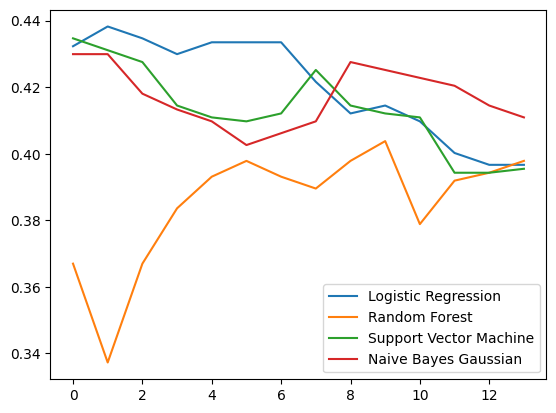

In [22]:
plt.plot(accuracy_total_list, label = ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Naive Bayes Gaussian'])
plt.legend()

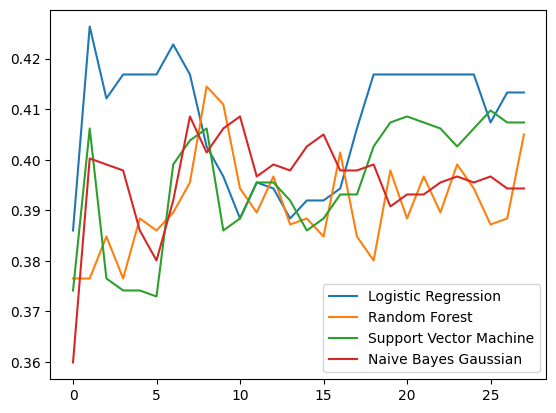

In [47]:
plt.plot(accuracy_total_list, label = ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Naive Bayes Gaussian'])
plt.legend()